<a href="https://colab.research.google.com/github/BenShieh233/NLP-Text-Mining/blob/main/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import string
import re
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from wordcloud import WordCloud

from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
fake = pd.read_csv("/content/drive/MyDrive/INFOSYS765/Fake.csv")

In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true = pd.read_csv("/content/drive/MyDrive/INFOSYS765/True.csv")

In [6]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## 1. Inspect the news content and clean the text

In [7]:
true['text'][0]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
wn = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize text
    tokens = text.split()

    # Remove stopwords, lemmatize and drop words length < 2
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords and len(word) > 2]
    
    return text

In [14]:
fake['text_preprocessed'] = fake['text'].apply(preprocess_text)
true['text_preprocessed'] = true['text'].apply(preprocess_text)

## 2. Generate word cloud for both 'true' and 'fake' news datasets.

In [26]:
def word_cloud(df):
  text = ''
  for words in df['text_preprocessed']:
      doc = ' '.join(words)
      text += doc
  plt.figure(figsize=(8,10))
  wc = WordCloud(max_words=1000,random_state=1).generate(text)
  plt.imshow(wc)
  plt.show()

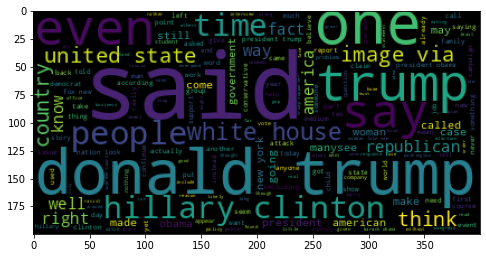

In [27]:
word_cloud(fake)

The theme of fake dataset is about politics. Because the words that have high frequency are the famous politicians like Donald Trump and Hilary Clinton. Words like "right", "country", "White House" are also topics about politics.

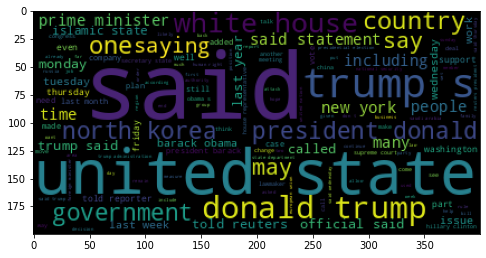

In [15]:
word_cloud(true)

Similarly, the theme of true dataset is also about politics, since words with high frequency include Donald Trump, government, president, north korea, and country.

## 3. K-means clustering

TF-IDF Representation

In [6]:
vectorizer = TfidfVectorizer(analyzer = preprocess_text, stop_words='english')
X = vectorizer.fit_transform(fake['text'])

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


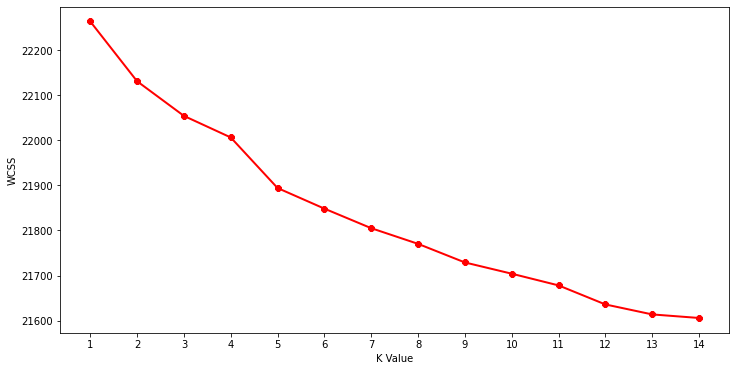

In [7]:
# array to store WCSS values
wcss=[]

# loops from 1-10 as values of k
for i in range(1,15):
    # creates KMeans objects and fits the data
    km=KMeans(n_clusters=i)
    km.fit(X)
    # stores WCSS value 
    wcss.append(km.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(1,15),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,15,1))
plt.ylabel("WCSS")
plt.show()

The elbow curve shows a significant drop in WCSS at K = 2 and K = 3. After k = 3, the shrinkage becomes smaller. Therefore, we conclude that the optimal number of clusters for the fake dataset is 3.

In [49]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),

Top terms per cluster:
Cluster 0:
 obama
 said
 people
 state
 police
 would
 black
 president
 one
 american
Cluster 1:
 clinton
 hillary
 email
 trump
 news
 fbi
 wire
 sander
 campaign
 president
Cluster 2:
 trump
 donald
 president
 republican
 said
 image
 campaign
 people
 would
 white


The first cluster might be about the first black president, Obama. The second cluster's topic is about the email scandal of Hillary Clinton which had been investigated by FBI. The last cluster might be about the president election, because Donald Trump, the candidate from Republicans, appear in the keywords.

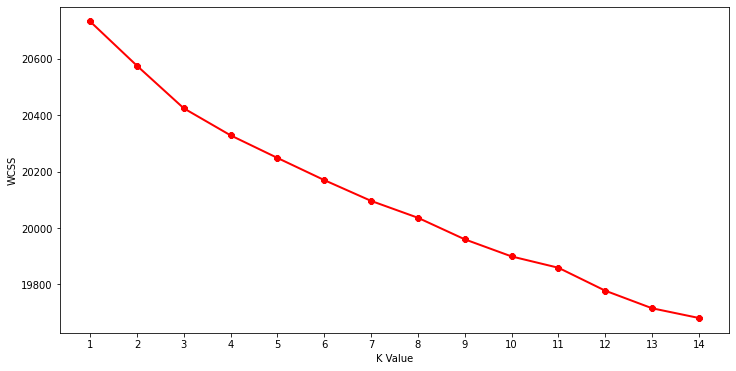

In [8]:
# Repeat the process on the true dataset.
vectorizer = TfidfVectorizer(analyzer = preprocess_text, stop_words='english')
X = vectorizer.fit_transform(true['text'])
# array to store WCSS values
wcss=[]

# loops from 1-10 as values of k
for i in range(1,15):
    # creates KMeans objects and fits the data
    km=KMeans(n_clusters=i)
    km.fit(X)
    # stores WCSS value 
    wcss.append(km.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(1,15),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,15,1))
plt.ylabel("WCSS")
plt.show()

We still cannot easily tell whether there is a significant drop in WCSS in the true dataset. Therefore, we still use k = 3 as usual to cluster the topics.

In [9]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),

Top terms per cluster:
Cluster 0:
 said
 state
 government
 minister
 party
 reuters
 would
 president
 united
 country
Cluster 1:
 korea
 north
 korean
 nuclear
 missile
 china
 south
 pyongyang
 said
 test
Cluster 2:
 trump
 republican
 said
 house
 tax
 would
 senate
 trump’s
 clinton
 president


The first cluster is about the president and government of the United States, since words like "president, united, minister, government, and state" appear in it. The second one could be about the nuclear weapon in north korea and the southern China sea. The reason is that "pyongyang", "missile", "nuclear", and "korean" appear in this cluster. The last topic is about Trump and Clinton's president election, and their topics that represent the parties they belong to, since "senate", "trump", "president" appear in such cluster.

# 4. LDA and topic modeling

In [11]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
     

In [15]:
data = fake['text_preprocessed'].values.tolist()
data_words = list(sent_to_words(data))

Setting the number of topics to 5

In [16]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [17]:
for idx in range(5):
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
print("=" * 20)

Topic #0: 0.009*"police" + 0.008*"shooting" + 0.007*"said" + 0.006*"black" + 0.006*"event" + 0.005*"wire" + 0.005*"one" + 0.005*"officer" + 0.004*"shooter" + 0.004*"student"
Topic #1: 0.024*"trump" + 0.009*"medium" + 0.008*"like" + 0.007*"president" + 0.006*"people" + 0.006*"political" + 0.006*"donald" + 0.006*"one" + 0.005*"say" + 0.005*"news"
Topic #2: 0.018*"clinton" + 0.014*"wire" + 0.012*"news" + 0.010*"fbi" + 0.009*"russian" + 0.009*"story" + 0.009*"russia" + 0.009*"medium" + 0.009*"cia" + 0.008*"intelligence"
Topic #3: 0.009*"state" + 0.008*"syria" + 0.007*"government" + 0.006*"century" + 0.005*"war" + 0.005*"would" + 0.005*"military" + 0.004*"also" + 0.004*"country" + 0.004*"american"
Topic #4: 0.008*"election" + 0.007*"state" + 0.007*"million" + 0.006*"party" + 0.006*"vote" + 0.006*"republican" + 0.005*"would" + 0.005*"rubio" + 0.005*"new" + 0.005*"democratic"


Modify the LDA model by setting the number of topics from two to ten.

In [21]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)
     

Coherence Score:  0.43512316685989083


In [20]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [22]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range: Number of Topics (K)
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter: Dirichlet hyperparameter alpha: Document-Topic Density
alpha = [0.01]
'''
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
'''

# Beta parameter: Dirichlet hyperparameter beta: Word-Topic Density
beta = [0.1]
'''
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
'''

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pbar.close()


  0%|          | 0/18 [12:24<?, ?it/s]

100%|██████████| 18/18 [2:36:38<00:00, 522.13s/it]


In [23]:
model_results = pd.DataFrame(model_results)
model_results

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.1,0.307804
1,75% Corpus,3,0.01,0.1,0.379610
2,75% Corpus,4,0.01,0.1,0.405726
3,75% Corpus,5,0.01,0.1,0.414337
4,75% Corpus,6,0.01,0.1,0.416156
5,75% Corpus,7,0.01,0.1,0.439334
6,75% Corpus,8,0.01,0.1,0.461607
7,75% Corpus,9,0.01,0.1,0.425663
8,75% Corpus,10,0.01,0.1,0.434128
9,100% Corpus,2,0.01,0.1,0.317373


We have obtained the highest coherence score, 0.519754 where there is a 100% validation set and 8 topics in total.

In [24]:
df1 = model_results[model_results['Validation_Set'] == "100% Corpus"]
x_values = df1['Topics'].values.tolist()
y_values = df1['Coherence'].values.tolist()

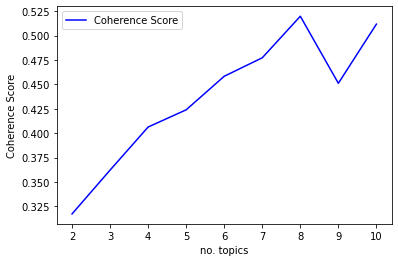

In [25]:
import matplotlib.pyplot as plt

plt.plot(x_values, y_values, 'b', label="Coherence Score")
plt.ylabel('Coherence Score')
plt.xlabel('no. topics')
plt.legend()
plt.show()
     

### Optimal Value

In [26]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [27]:
for idx in range(8):
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
print("=" * 20)

Topic #0: 0.020*"student" + 0.020*"woman" + 0.019*"child" + 0.016*"school" + 0.014*"university" + 0.012*"orlando" + 0.008*"mateen" + 0.008*"church" + 0.008*"militant" + 0.007*"campus"
Topic #1: 0.008*"century" + 0.007*"people" + 0.007*"war" + 0.007*"one" + 0.006*"like" + 0.006*"wire" + 0.005*"world" + 0.005*"america" + 0.005*"american" + 0.005*"would"
Topic #2: 0.044*"trump" + 0.020*"medium" + 0.017*"news" + 0.011*"hillary" + 0.011*"donald" + 0.009*"clinton" + 0.009*"president" + 0.008*"cnn" + 0.007*"mainstream" + 0.007*"campaign"
Topic #3: 0.038*"syria" + 0.019*"syrian" + 0.017*"terrorist" + 0.016*"state" + 0.014*"court" + 0.013*"law" + 0.012*"federal" + 0.011*"government" + 0.011*"isi" + 0.010*"order"
Topic #4: 0.020*"police" + 0.018*"shooting" + 0.011*"said" + 0.010*"officer" + 0.010*"black" + 0.010*"shooter" + 0.008*"shot" + 0.008*"event" + 0.008*"gun" + 0.007*"city"
Topic #5: 0.011*"state" + 0.007*"election" + 0.007*"party" + 0.007*"would" + 0.006*"million" + 0.006*"new" + 0.006*"

In the fake dataset, the optimal number is 8. The themes of each topic are as follows:
Topic 0: education and  ("student", "school", "university", "campus")  
Topic 1: international issues ("american", "war", "world", "century")  
Topic 2: president election ("trump", "clinton", "president", "cnn")  
Topic 3: national defense ("syria", "terrorist", "court", "law")  
Topic 4: gun violence ("black", "shooting", "police", "gun")  
Topic 5: election & voting ("vote", "party", "government", "million", "election")  
Topic 6: research & religion ("evangelist", "savant", "custommade")  
Topic 7: Hillary email scandal ("fbi", "clintoin", "russia", "wire", "cia")

To avoid too much resources occupied, we simply assume that the optimal number of topics in the true dataset is also 8. Then we rerun the model in the dataset.

In [29]:
data = true['text_preprocessed'].values.tolist()
data_words = list(sent_to_words(data))
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
for idx in range(8):
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
print("=" * 20)

Topic #0: 0.024*"said" + 0.009*"people" + 0.007*"one" + 0.006*"year" + 0.005*"many" + 0.005*"time" + 0.005*"reuters" + 0.004*"told" + 0.004*"mexico" + 0.004*"president"
Topic #1: 0.030*"company" + 0.019*"oil" + 0.015*"bank" + 0.015*"power" + 0.011*"firm" + 0.011*"business" + 0.010*"energy" + 0.009*"industry" + 0.008*"economy" + 0.008*"corruption"
Topic #2: 0.026*"said" + 0.014*"north" + 0.013*"state" + 0.013*"korea" + 0.012*"minister" + 0.010*"united" + 0.009*"would" + 0.007*"president" + 0.007*"nuclear" + 0.007*"reuters"
Topic #3: 0.028*"said" + 0.011*"military" + 0.010*"force" + 0.010*"myanmar" + 0.009*"reuters" + 0.009*"state" + 0.008*"rohingya" + 0.008*"china" + 0.007*"army" + 0.007*"security"
Topic #4: 0.020*"said" + 0.016*"police" + 0.014*"court" + 0.012*"government" + 0.011*"right" + 0.010*"state" + 0.009*"people" + 0.008*"refugee" + 0.007*"group" + 0.007*"law"
Topic #5: 0.029*"said" + 0.014*"russia" + 0.014*"russian" + 0.013*"reuters" + 0.011*"investigation" + 0.011*"turkey" + 

In the true dataset, the optimal number is 8. The themes of each topic are as follows:
Topic 0: news ("year", "people", "reuters", "mexico")  
Topic 1: economy ("oil", "bank", "firm", "business","industry","economy")  
Topic 2: north korea ("north korea", "nuclear", "united", "president")  
Topic 3: south-eastern Asia ("myanmar", "rohingya", "army", "china")  
Topic 4: laws ("court", "refugee", "police", "right")  
Topic 5: Russia ("Moscow", "turkey", "russian", "president", "Erdogan")  
Topic 6: policy ("government", "reform", "billion")  
Topic 7: president election ("fbi", "election", "party", "opposition", "conservative")

## 5. Comparison and Summary

Overall, the results from the three methods are consistent. One of the common topics in the fake dataset is the president election. And the overlapped topic in the true dataset is also president election. Hence, the results are all consistent. However, based on the performance, I think LDA gives the most reasonable results in terms of giving the optimal number of topics. In word cloud and K-means clusters, we could still find topics that are mixtures of other topics and some of the words are overlapped, indicating a low coherence between words. For example, all topics in the K-means clustering contain information about Donald Trump and the US president election. On the other side, LDA successfully categorize the topics in a sense that improves the coherence score within a specific topic. It extract the hidden topics from the K-means clusters and thus make them more reasonable to become separate.For example, in the true dataset, LDA could recognize the news from different countries in the world and the domestic news in the USA, which make the categorization more reasonable.